In [2]:
import pandas as pd
import numpy as np
import glob
import os
import re
import math
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import container
%matplotlib widget

# Importing files as dataframes using their path

In [3]:
data_dict = {}

pathL = Path('../data/raw/Loading/RvsT/')  #importing the warming data files for loading set of experiments
pathUL = Path('../data/raw/Unloading/RvsT/')  #importing the warming data files for unloading set of experiments

for file in pathL.iterdir() :
    if str(file).endswith('.csv'):
        file_num = int(re.split('_', str(file.name))[0]) 
        data_dict[file_num] = pd.read_csv(
        file,
        delimiter='\t',
        usecols=[2, 3],
        skiprows=[0],
        names=['Temp','V']
        ).dropna()
for file in pathUL.iterdir() :
    if str(file).endswith('.csv'): 
        file_num = int(re.split('_', str(file.name))[0])
        data_dict[file_num] = pd.read_csv(
        file,
        delimiter='\t',
        usecols=[2, 3],
        skiprows=[0],
        names=['Temp','V']
        ).dropna()

#Unwanyted file numbers 34 35 36 44 45 46
#Plotting the data files reistance vs temperature data 


In [4]:
dict_CD = {} #declaring dictionary for Current dependence measurements

In [5]:
# #Filtering unwanted files using file number
for file_num in [34, 35, 36 ,44,45,46, 50,51,52]: #files associted with current dependence measurements
    dict_CD[file_num] = data_dict[file_num]
    data_dict.pop(file_num)

In [6]:
data_dict = dict(sorted(data_dict.items()))

In [7]:
data_dict.keys()

dict_keys([2, 10, 14, 17, 20, 23, 26, 29, 32, 33, 39, 41, 43, 48, 49, 53, 54])

### Making a dictionary with pressure values

In [8]:
P = [9.6, 18, 30, 44, 53, 62, 74, 87, 98, 104, 110, 145, 155,140, 128, 95, 20] #Pressure values for Tc measurements
P_CD = [104, 155, '123*'] #Pressure for current dependence measuremenet

## Plotting Resistance vs Temperature

In [ ]:
fig, ax = plt.subplots()
i =0
for file in data_dict.keys(): #Plotting Unloading data files
        df = data_dict[file]
        df['R'] = df.V.rolling(100, center=True).mean()/0.003 # taking moving average using rolling around center.
        df = df[(df.Temp.diff().abs() < 5) & (df.R<10)]# filtering out the data points where Temperature has offset points due to instrumental noise.
        if file < 42:  #Files for loading pressure
            ax.plot(df.Temp, df.R*1000, label=P[i])
        else:          #Files for unloading pressure
            ax.plot(df.Temp, df.R*1000, label=str(P[i])+'*')
        i=i+1
    
ax.legend(title ='P (GPa), Unloading',bbox_to_anchor=(0.0, 0.3, 1., .102),loc = 'lower right', borderpad = 0.08, labelspacing = 0.2,ncol = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(axis="both",which = 'major', direction="in", length=5, width=1, top = True,right = True)
ax.tick_params(axis="both",which = 'minor', direction="in", length=3, width=1, top = True, right = True)
ax.set_xlim(0,300)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Resistance(m$\Omega$)')
ax.text(180,.006,'* = Pressure being released')

#adding secondary y-axis for estimated Resistivity
rho = lambda Re : Re*0.004532 #Approximate value of (pi*10)/ln(2))*(10^(-4)) using formula for vande-paw set up
Re = lambda rho: rho/0.004532
ax2 = ax.secondary_yaxis("right",functions= (rho,Re))
ax2.set_ylabel('Estimated Resistivity (m$\Omega$-cm)')
plt.tight_layout()
plt.savefig('../publication_ready/R_vs_T.pdf')

In [ ]:
plt.close('all')

In [ ]:
# for file, df in data_dict.items():
#     R_normal = df.R[df.Temp > 30].iloc[0]
#     try:
#         print(p_dict[file], df.Temp[df.R > 0.9 * R_normal].iloc[0])
#     except:
#         pass

## Plotting Tc vs P

In [ ]:
#Using Voltage at 30 K as the V(100%) at onset
V_N= [] # empty list for normal state voltage at 300 K
i = 0;
for f in data_dict:    
    #print(data_dict[f].query("(Temp >29.5)&(Temp<31.5)")["V"].mean())
    V_N.append(data_dict[f].query("(Temp >29.5)&(Temp<31.5)")["V"].mean())
    i=i+1;

### Getting Tc 90%, Tc 50% and Tc 10%

In [ ]:
j=0
Tc_90= []
Tc_50 = []
Tc_10= []
for file in data_dict:
    pos90 = abs(data_dict[file].V-(0.9*V_N[j])).abs().idxmin() #This fails for incomplete transitions
    if abs((100*(data_dict[file].V[pos90]-V_N[j])/V_N[j])) < 9.5:
        Tc_90.append(np.NaN)
    else:
         Tc_90.append(data_dict[file].Temp[pos90])
        
    pos50 = abs(data_dict[file].V-(0.5*V_N[j])).abs().idxmin() #This fails for incomplete transitions
    if abs((100*(data_dict[file].V[pos50]-V_N[j])/V_N[j])) < 49.5:
        Tc_50.append(np.NaN)
    else: 
        Tc_50.append(data_dict[file].Temp[pos50])
        
    pos10 = abs(data_dict[file].V-(0.1*V_N[j])).abs().idxmin() #This fails for incomplete transitions
    if abs((100*(data_dict[file].V[pos10]-V_N[j])/V_N[j])) < 89.5:
        Tc_10.append(1.8)
    else: 
        Tc_10.append(data_dict[file].Temp[pos10])    
    j = j+1

In [ ]:
df_mob2 = pd.read_csv('../data/external/combined.csv', skiprows = [0],names = ['Pressure', 'Tc'])

In [ ]:
fig, ax = plt.subplots()
yerr_min = np.array(Tc_50) - np.array(Tc_10)
yerr_max = np.array(Tc_90) - np.array(Tc_50)
y_err = [yerr_min, yerr_max]
#x_err = 0.1*np.array(P) 
ax.errorbar(P[3:5],Tc_90[3:5],yerr = [np.array(Tc_90[3:5])-1.8*np.ones(2), np.zeros(2),], fmt = '',color = 'k', ls = 'none') 
ax.errorbar(P[3:5],Tc_90[3:5],yerr = 0, fmt = '',solid_capstyle= 'projecting', capsize = 5,color = 'k', ls = 'none')
ax.errorbar(P[4:11],Tc_50[4:11], yerr= [yerr_min[4:11], np.zeros(7)],  fmt = 'o', markersize=8, color = 'k') #, solid_capstyle='projecting', capsize=5
ax.errorbar(P[5:11],Tc_50[5:11], yerr= [np.zeros(6), yerr_max[5:11]], xerr = 0.05*np.array(P[5:11]), fmt = 'o', markersize=8, solid_capstyle='projecting', capsize = 5, 
            color = 'k', 
            label= 'Loading')
ax.errorbar(P[11:13], Tc_50[11:13], yerr = [yerr_min[11:13],yerr_max[11:13]], xerr = 0.05*np.array(P[11:13]), fmt = 'o', markersize = 8, solid_capstyle = 'projecting', 
            capsize = 5, color = 'k')
ax.errorbar(P[13:18], Tc_50[13:18], yerr = [yerr_min[13:18],yerr_max[13:18]], xerr = 0.05*np.array(P[13:18]), fmt = 'o', markersize = 8, solid_capstyle= 'projecting', 
            capsize = 5, color = 'r', label = 'Unloading')
ax.vlines(68, 0,35,'m','dashed', label = 'MoB$_2$ (C. Pei $et$ $al.$)', alpha = 0.4, linewidth = 4, color = 'skyblue')
ax.vlines(47.712, 0,35,'m','dashed', label = 'phase transition')
ax.plot(df_mob2.Pressure, df_mob2.Tc, 's', alpha = 0.4, color= 'skyblue')
ax.set_xlabel('Pressure (GPa)')
ax.set_ylabel('T$_c$ (K)')
#ax.legend(loc = 'upper left', borderpad = 0.08, labelspacing = 0.2,ncol = 1)
handles, labels = ax.get_legend_handles_labels()
handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]

ax.legend(handles, labels)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(axis="both",which = 'major', direction="in", length=5, width=1, top = True,right = True)
ax.tick_params(axis="both",which = 'minor', direction="in", length=3, width=1, top = True, right = True)
ax.set_xlim(0,180)
ax.set_ylim(0,35)
plt.tight_layout()

#### Plotting Tc vs P with errorbars

In [ ]:
# plt.savefig('../publication_ready/Tc_vs_Pressure.pdf')

In [ ]:
plt.close('all')

## Change in Resistance with pressure at different temperatures

In [9]:
R_285= []
R_150 = []
R_10 = []# empty list for normal state voltage at 300 K
i = 0;
for f in data_dict:    
    V285 = data_dict[f].query("(Temp >284.5)&(Temp<285.5)")["V"].mean()
    V150 = data_dict[f].query("(Temp >149.5)&(Temp<151.5)")["V"].mean()
    V10 = data_dict[f].query("(Temp >9.9)&(Temp<10.1)")["V"].mean()
    R_285.append(V285/0.000003) # in milliOhms
    R_150.append(V150/0.000003)
    R_10.append(V10/0.000003)
    i=i+1;

Text(0, 0.5, 'Estimated Resistivity (m$\\Omega$-cm)')

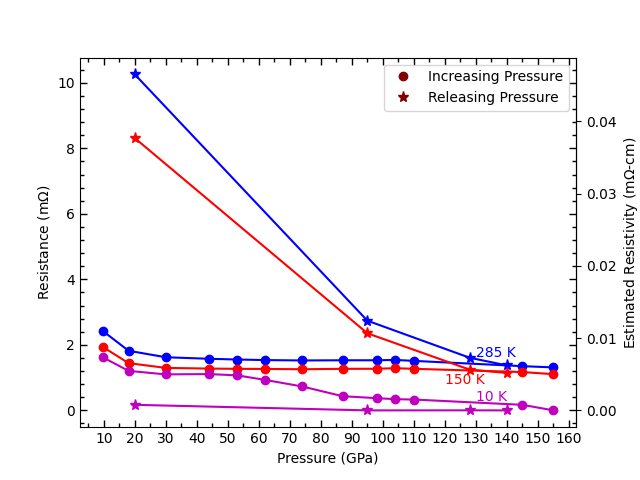

In [47]:
import matplotlib.lines as mlines
fig,ax = plt.subplots()
#Plotting Loading data

ax.plot(P[0:13], R_285[0:13], '-o', color = 'b', )
ax.plot(P[0:13], R_150[0:13], '-o', color = 'r')
ax.plot(P[0:13], R_10[0:13], '-o', color = 'm')

#Plotting Unloading

ax.plot(P[13:18], R_285[13:18], '-*',markersize = 8, color = 'b')
ax.plot(P[13:18], R_150[13:18], '-*', markersize = 8, color = 'r')
ax.plot(P[13:18], R_10[13:18], '-*',markersize = 8, color = 'm')

ax.text(130,1.62, '285 K', color = 'b')
ax.text(120,0.8, '150 K', color = 'r')
ax.text(130,0.3, '10 K', color = 'm')
ax.set_xlabel('Pressure (GPa)')
ax.set_ylabel('Resistance (m$\Omega$)')

#Defining Legend handles, Defining empty lines for legend handles

sphere = mlines.Line2D([],[],color = 'maroon',marker = 'o', linestyle = 'None',
                       markersize = 6, label = 'Increasing Pressure')
star = mlines.Line2D([], [], color='maroon', marker='*', linestyle='None',
                          markersize=8, label='Releasing Pressure')

ax.legend(handles = [sphere,star])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.tick_params(axis="both",which = 'major', direction="in", length=5, width=1, top = True,right = True)
ax.tick_params(axis="both",which = 'minor', direction="in", length=3, width=1, top = True, right = True)

rho = lambda Re : Re*0.004532 #Approximate value of (pi*10)/ln(2))*(10^(-4)) using formula for vande-paw set up. Re  = Resitance, pho = resistivity
Re = lambda rho: rho/0.004532 #establishing relation between resitance and resistivity
ax2 = ax.secondary_yaxis("right",functions= (rho,Re))
ax2.set_ylabel('Estimated Resistivity (m$\Omega$-cm)')
        




In [48]:
plt.savefig('../publication_ready/Resistance_Vs_Pressure_LandUL.pdf')

In [50]:
plt.close('all')

### Plotting Current Dependence at different pressure

In [ ]:
dict_CD[50].drop(dict_CD[50].index[0:26160], inplace = True)
dict_CD[51].drop(dict_CD[51].index[0:8612], inplace = True)
dict_CD[52].drop(dict_CD[52].index[0:7912], inplace = True)

In [ ]:
fig,ax = plt.subplots()
for file in dict_CD:   
    i = i+1
    df = dict_CD[file][dict_CD[file].Temp<40]
    if file in [34, 44]:  #Current Dependence at 104 GPa
        ax.plot(df.Temp, df.V.rolling(100, center=True).mean()/0.000003, color = 'r')
    elif file in [35, 45]: #Current Dependence at 123 GPa
        ax.plot(df.Temp, df.V.rolling(50, center=True).mean()/0.00001, color = 'b')
    elif file in [36, 46]: #Current Dependence at 104 GPa
        ax.plot(df.Temp, df.V.rolling(20, center=True).mean()/0.00003, color = 'm')
        #Showing unloading data as faded
    if file == 50:
        ax.plot(df.Temp, df.V.rolling(100, center=True).mean()/0.000003, color = 'r', alpha = 0.6)
    elif file == 51:
        ax.plot(df.Temp, df.V.rolling(50, center=True).mean()/0.00001, color = 'b', alpha = 0.6)
    elif file == 52:
        ax.plot(df.Temp, df.V.rolling(20, center=True).mean()/0.00003, color = 'm', alpha = 0.6)
        

ax.text(35,1.05, '104 GPa',color = 'maroon')
ax.text(35,1.18, '123 GPa', color = 'maroon')
ax.text(35,0.88, '155 GPa', color = 'maroon')

ax.set_title('Current Dependence Measurements')
ax.legend(['0.1 mA','1 mA','3 mA'])
ax.set_xlim(1, 40)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Resistance (m$\Omega$)')
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.tick_params(axis="both",which = 'major', direction="in", length=5, width=1, top = True,right = True)
ax.tick_params(axis="both",which = 'minor', direction="in", length=3, width=1, top = True, right = True)

In [ ]:
plt.savefig('../publication_ready/CurrentDependenceMeasurement.pdf')

In [ ]:
plt.close('all')

In [ ]:
plt.stem